In [249]:
import sys
try:
    from pyathena import connect
except:
    print("Failed to import pyathena, trying to install it")
    !{sys.executable} -m pip install PyAthena
    from pyathena import connect
    print("successfully installed")
try:
    import psycopg2
except:
    print("Failed ot import psychopg2, trying to install it")
    !{sys.executable} -m pip install psycopg2-binary
    import psycopg2
    print("Successfully installed")
import pandas as pd
import boto3
import boto3
import base64
from botocore.exceptions import ClientError
from datetime  import datetime, timedelta

In [ ]:
# if using jupyterlab and plotly doesn't work https://plot.ly/python/getting-started/#jupyterlab-support-python-35
install_jupyterlab_plotly_extensions_command = """
# Avoid "JavaScript heap out of memory" errors during extension installation
# (OS X/Linux)
export NODE_OPTIONS=--max-old-space-size=4096
# (Windows)
set NODE_OPTIONS=--max-old-space-size=4096

# Jupyter widgets extension
jupyter labextension install @jupyter-widgets/jupyterlab-manager@1.0 --no-build

# jupyterlab renderer support
jupyter labextension install jupyterlab-plotly@1.1.0 --no-build

# FigureWidget support
jupyter labextension install plotlywidget@1.1.0 --no-build

# JupyterLab chart editor support (optional)
jupyter labextension install jupyterlab-chart-editor@1.2 --no-build

# Build extensions (must be done to activate extensions since --no-build is used above)
jupyter lab build

# Unset NODE_OPTIONS environment variable
# (OS X/Linux)
unset NODE_OPTIONS"""



    

In [258]:
import plotly.graph_objects as go
import plotly as py

import plotly.offline as off
import plotly.graph_objs as go
import numpy as np
from plotly.subplots import make_subplots

# off.init_notebook_mode(connected=True)

In [2]:
s3_client = boto3.client('s3')
s3_resource = boto3.resource('s3') #slower, but easier
# s3_conn = boto3.s3.connect_to_region('us-west-2')

athena = boto3.client('athena')

In [3]:
#--- Settings -- 
event_log_s3_path = "s3://ms-data-pipeline-production/ms-data-stream-production-processed"
event_log_s3_bucket = event_log_s3_path.split("s3://")[1].split("/")[0]
event_log_s3_prefix = event_log_s3_path.split("/")[-1]
athena_bucket_path = "s3://aws-athena-query-results-358002497134-ap-southeast-1/"
athena_raw_events_table = "ms_data_stream_production_processed"
athena_easy_events_table =  "id_ab_test"
aws_region_name = "ap-southeast-1"

# --
list_out_s3_bucket = False #extremely slow.


In [6]:
print("Connecting to Athena")
athena_conn = connect(s3_staging_dir=athena_bucket_path, region_name=aws_region_name)

Connecting to Athena


In [179]:
print("Testing that the athena connection actually does something")
test_query = "select * from id_ab_test limit 1000"
events = pd.read_sql(test_query, athena_conn)


Testing that the athena connection actually does something


In [182]:
pageview_events = events[events.event_name=="PageView"]

In [19]:
def get_list_of_expected_s3_folders_and_date_keys():
    # s3://ms-data-pipeline-production/ms-data-stream-production-processed/2019/08/02
    root_path = event_log_s3_path
    paths = []
    start_date = datetime(year=2019, month = 6, day = 18)
    now = datetime.now() #TODO: the timezone seems wrong :(
    print(now)
    day_increment = timedelta(days=1)
    processing_day = start_date
    while processing_day<now: #should include the current day
        day_suffix = "%.4i/%.2i/%.2i/" % (processing_day.year, processing_day.month, processing_day.day)
        day_index = "%.4i-%.2i-%.2i" % (processing_day.year, processing_day.month, processing_day.day)
        paths.append([root_path+"/"+day_suffix, day_index])
        processing_day += day_increment
    return paths
expected_paths_sent_ats = get_list_of_expected_s3_folders_and_date_keys()

2019-09-03 06:58:11.502005


In [20]:
expected_paths_sent_ats[:5]+ expected_paths_sent_ats[-5:]

[['s3://ms-data-pipeline-production/ms-data-stream-production-processed/2019/06/18/',
  '2019-06-18'],
 ['s3://ms-data-pipeline-production/ms-data-stream-production-processed/2019/06/19/',
  '2019-06-19'],
 ['s3://ms-data-pipeline-production/ms-data-stream-production-processed/2019/06/20/',
  '2019-06-20'],
 ['s3://ms-data-pipeline-production/ms-data-stream-production-processed/2019/06/21/',
  '2019-06-21'],
 ['s3://ms-data-pipeline-production/ms-data-stream-production-processed/2019/06/22/',
  '2019-06-22'],
 ['s3://ms-data-pipeline-production/ms-data-stream-production-processed/2019/08/30/',
  '2019-08-30'],
 ['s3://ms-data-pipeline-production/ms-data-stream-production-processed/2019/08/31/',
  '2019-08-31'],
 ['s3://ms-data-pipeline-production/ms-data-stream-production-processed/2019/09/01/',
  '2019-09-01'],
 ['s3://ms-data-pipeline-production/ms-data-stream-production-processed/2019/09/02/',
  '2019-09-02'],
 ['s3://ms-data-pipeline-production/ms-data-stream-production-processed/2

In [24]:
def add_partitions(paths_sent_ats):
    print("Adding partitions")
    for path, sent_at in paths_sent_ats:
        print("adding partition for %s" % sent_at)
        query = "ALTER TABLE %s ADD PARTITION (sent_at='%s') location '%s';"%(athena_raw_events_table, sent_at, path)
        print(query)
        pd.read_sql(query, athena_conn)

In [25]:
add_partitions(expected_paths_sent_ats)

Adding partitions
adding partition for 2019-06-18
ALTER TABLE ms_data_stream_production_processed ADD PARTITION (sent_at='2019-06-18') location 's3://ms-data-pipeline-production/ms-data-stream-production-processed/2019/06/18/';


DatabaseError: Execution failed on sql: ALTER TABLE ms_data_stream_production_processed ADD PARTITION (sent_at='2019-06-18') location 's3://ms-data-pipeline-production/ms-data-stream-production-processed/2019/06/18/';
FAILED: SemanticException table is not partitioned but partition spec exists: {sent_at=2019-06-18}
unable to rollback

In [193]:


# TODO: the right way to do this would be to store connection details in the secrets manager.  Unfortunately not working :(
def get_secret():

    secret_name = "data_pier"
    region_name = "ap-southeast-1"

    # Create a Secrets Manager client
    session = boto3.session.Session()
    client = session.client(
        service_name='secretsmanager',
        region_name=region_name
    )


    # See https://docs.aws.amazon.com/secretsmanager/latest/apireference/API_GetSecretValue.html
    # I've deleted a chunk of error handling bumpf

    get_secret_value_response = client.get_secret_value(
        SecretId=secret_name
    )


def get_data_pier_connection():
    db_pass = input()
    db_host = "data-pier-production.cl8qfdl47mtr.ap-southeast-1.rds.amazonaws.com"
    db_user = "jamie"
    db_database = "data_pier"
    pg_conn = psycopg2.connect(host=db_host, user = db_user, dbname=db_database, password= db_pass)
    pg_conn.set_session(readonly=True, autocommit=True) #without this it can lock tables.
    
    
    return pg_conn, pg_conn.cursor()


In [195]:
pg_conn, cursor = get_data_pier_connection()
cursor.execute("select * from information_schema.tables limit 10")

 BVHSjgnqHpqPRgHHaG9sYdJqD94ZeykJ


In [199]:
#query = "select * from information_schema.columns where table_schema='id_wordpress'" 
query = "select  * from id_wordpress.wp_terms join id_wordpress.wp_posts where slug like '%kartu%' limit 100" # gets slug
query = """
        select * from id_wordpress.wp_postmeta where meta_key not like'%oembed%' 
        and meta_key like '%slug%'
        order by meta_key desc limit 100
        """

query = "select taxonomy, count(*) from id_wordpress.wp_term_taxonomy group by taxonomy"
query = "select * from id_wordpress.wp_term_taxonomy where taxonomy='post_tag'"
pd.read_sql_query(query, pg_conn).head()

,term_taxonomy_id,term_id,taxonomy,description,parent,count
0,577.0,577.0,post_tag,,0.0,133
1,582.0,582.0,post_tag,,0.0,20
2,583.0,583.0,post_tag,,0.0,47
3,586.0,586.0,post_tag,,0.0,117
4,591.0,591.0,post_tag,,0.0,56


In [83]:
pps_query = """
select users.day_str, users.is_test, num_users, num_pageviews, cast(num_pageviews as DOUBLE) / (num_users) as pageviews_per_user_per_day from 

(select day_str, is_test, count(distinct(anonymous_id)) AS num_users from id_pageview_metrics group by day_str, is_test) as users

JOIN

(select day_str, is_test, count(*) as num_pageviews from id_pageview_metrics group by day_str, is_test) as pageviews

ON 
 users.day_str = pageviews.day_str
 and 
 users.is_test = pageviews.is_test
order by day_str, is_test
"""
pageviews_per_session = pd.read_sql_query(pps_query, athena_conn)

In [84]:
pageviews_per_session


,day_str,is_test,num_users,num_pageviews,pageviews_per_user_per_day
0,2019-08-29,False,22667,27063,1.193938
1,2019-08-29,True,778,1003,1.289203
2,2019-08-30,False,147652,178157,1.206601
3,2019-08-30,True,5432,6586,1.212445
4,2019-08-31,False,146489,177051,1.208630
5,2019-08-31,True,4999,5962,1.192639
6,2019-09-01,False,150252,180434,1.200876
7,2019-09-01,True,5429,6314,1.163013
8,2019-09-02,False,150894,182569,1.209916
9,2019-09-02,True,5893,7009,1.189377


In [85]:
pageviews_per_session.groupby(['is_test']).mean()

,num_users,num_pageviews,pageviews_per_user_per_day
is_test,,,
False,130656.857143,157664.428571,1.205112
True,4778.571429,5664.714286,1.198417


In [210]:
def get_all_categories_tags(conn, schema):
    
    """domain.com/<slug> (we can parse the slug based on URL single post format)
Get the post from slug
```sql
SELECT wp_posts.*
FROM wp_posts 
WHERE 1=1 
AND wp_posts.post_name = '<slug>'
AND wp_posts.post_type = 'post' 
ORDER BY wp_posts.post_date DESC
```
Get categories of a post (post_id is from post retrieved above). For tag, replace 'category' by 'tag'
```sql
SELECT t.term_id, tt.parent, tt.count, tt.taxonomy
FROM wp_terms AS t 
INNER JOIN wp_term_taxonomy AS tt
ON t.term_id = tt.term_id
INNER JOIN wp_term_relationships AS tr
ON tr.term_taxonomy_id = tt.term_taxonomy_id
WHERE tt.taxonomy IN ('category')
AND tr.object_id IN (<post_id>)
ORDER BY t.name ASC
```
Get details of a term (category or tag) from IDs retrieved above
```sql
SELECT t.*, tt.*
FROM wp_terms AS t
INNER JOIN wp_term_taxonomy AS tt
ON t.term_id = tt.term_id
WHERE t.term_id = <term_id>
```"""
    
    
    tags_categories_query = """
    select 
        wp_posts.id as post_id, 
        -- wp_posts.post_name as slug, 
        cats.name, 
        cats.term_id, 
        cats.parent, 
        cats.count, 
        cats.taxonomy
    
    from {schema}.wp_posts
    join (
        SELECT tr.object_id, t.term_id, tt.parent, tt.count, tt.taxonomy, t.name
        FROM {schema}.wp_terms AS t 
        INNER JOIN {schema}.wp_term_taxonomy AS tt
        ON t.term_id = tt.term_id
        INNER JOIN {schema}.wp_term_relationships AS tr
        ON tr.term_taxonomy_id = tt.term_taxonomy_id
         WHERE tt.taxonomy IN ('category', 'post_tag')
       
        
    ) as cats
    on cats.object_id = wp_posts.id
    
    where
    wp_posts.post_type = 'post'
    and wp_posts.post_status = 'publish'
    
    """.format(schema=schema)

    
    
    tags_categories = pd.read_sql_query(tags_categories_query, conn)
    #print(tags_categories[:100])
    
    print(tags_categories.head())
    tags_categories.astype({"post_id":int, "term_id":int, "parent":int, "taxonomy": "category"}) #untested type casting
    
    
    tags = tags_categories[tags_categories.taxonomy=='post_tag'][['post_id','name']]
    
    categories = tags_categories[tags_categories.taxonomy=='category'][['post_id','name']]
    
    
    return categories, tags


def get_post_data(conn, schema):
    query = """
    select id as post_id, post_name as slug, post_author as author_id, CHAR_LENGTH(post_content) as post_num_chars, post_date, post_modified 
    from {schema}.wp_posts
    
    where 
    wp_posts.post_type = 'post'
    and wp_posts.post_status = 'publish'
    """.format(schema=schema)
    df = pd.read_sql_query(query, conn)
    df.astype({"post_id":int, "author_id":int}) #untested type casting
    return df
    
def slug_to_url(slug):
    return "https://www.moneysmart.id/"+slug



post_data = get_post_data(pg_conn, "id_wordpress")
    
post_slugs_to_id_df = post_data[["post_id",]] #.index(post_data["slug"])

categories, tags = get_all_categories_tags(pg_conn, "id_wordpress")
                                           

   post_id                       name  term_id  parent  count  taxonomy
0    153.0                   Pinjaman    528.0  1180.0    504  category
1    155.0                  Budgeting   1193.0  1191.0    616  category
2    155.0                 tips hemat   1299.0     0.0    175  post_tag
3    155.0  mengatur keuangan pribadi   1944.0     0.0      5  post_tag
4    155.0              mengatur uang   3053.0     0.0      5  post_tag


In [226]:
def convert_canonical_url_to_slug(url):
    if "//" not in url:
        raise Exception("expected start of url in {}".format(url))
    id_root = "https://www.moneysmart.id"
    ms_id_index = url.find(id_root)
    if not ms_id_index:
        raise Exception("{url} doesn't look like a canonical url".format(url = url))
        
    slug = url[ms_id_index+ len(id_root)+1:].strip("/")
    
    if slug == "":
        slug ="/"
    return slug
        
def is_article_slug(slug):
    if "/" in slug or len(slug)==0:
        return False
    return True

def get_post_id_from_slug(slug):
    post_id = post_slugs_to_id_df.loc[slug, :][0]
    return post_id


def get_post_id_from_url(url):
    #Expects only post urls
    slug = convert_canonical_url_to_slug(url)
    print(slug)
    post_id = get_post_id_from_slug(slug)
    return post_id

In [228]:
post_slugs_to_id_df.head()

,post_id
0,153.0
1,155.0
2,158.0
3,161.0
4,199.0


In [227]:
get_post_id_from_url("htts://www.moneysmart.id/cara-cepat-melunasi-kpr")

cara-cepat-melunasi-kpr


KeyError: 'cara-cepat-melunasi-kpr'

In [183]:
categories.head(5)

,id,slug,name
0,153.0,cara-cepat-melunasi-kpr,Pinjaman
1,155.0,mengatur-keuangan-pribadi,Budgeting
6,158.0,kpr-rumah-dan-cara-memilihnya,Pinjaman
10,161.0,agar-otak-selalu-segar,Ragam
11,171.0,tips-menambah-teman-dan-berbelanja-saat-berlibur,Kuliner &amp; Travel


In [128]:
import time

In [152]:
article_categories = categories.groupby('slug').aggregate(lambda x:x.unique().tolist())
article_tags = tags.groupby('slug').aggregate(lambda x:x.unique().tolist())

In [141]:
#[z for z in article_categories.values if len(z[1])>0]
article_categories
article_categories['num_categories'] = article_categories['name'].apply(len)

In [177]:
#TODO: sometime should do all this based on post_id

def get_categories_tags_for_url(slug):
    #cats = categories[categories.slug==slug]
    try:
        tags = article_tags.loc[slug, :][1]
    except:
        print("no tags")
        tags = []
    try:
        cats = article_categories.loc[slug, :][1]
    except:
        print("no categories for %s"%slug)
        cats = []
    return cats, tags

def get_category_tags_for_url(slug):
    """
    this returns just the first category (and maybe not even the primary category... yet)
    It's useful for grouping easily by category without duplication.
    """
    cats, tags = get_categories_tags_for_slug()

start_time = time.time()
cats, tags = get_categories_tags_for_url("pembalap-indonesia-berkarier-di-mancanegara")
end_time = time.time()

print("it took ")
print(end_time-start_time)
cats_tags

it took 
0.0007693767547607422


(['Inspirasi'],
 ['pembalap',
  'pembalap indonesia',
  'pembalap indonesia berkarier hingga mancanegara'])

In [253]:
#pageviews_with_categories = pageview_events.join()
events.head()

,sent_at_timestamp,sent_at,type,event_name,status,article_read_depth,anonymous_id,canonical_url,page_url,is_amp,has_marketing_param,is_test,is_control
0,2019-09-03 23:47:24.676,2019-09-03T23:47:24.676Z,event,Reading,Article Body 50,50,23e29496-49af-4b8c-b7a3-6755efb15a22,https://www.moneysmart.id/usaha-modal-10-juta-...,https://www.moneysmart.id/usaha-modal-10-juta-...,False,True,False,True
1,2019-09-03 23:47:23.679,2019-09-03T23:47:23.679Z,event,Reading,Article Body 50,50,ea8cb9ae-bf5f-4f4d-9bf8-a0b912c0c3cf,https://www.moneysmart.id/ustadz-abdul-somad-m...,https://www.moneysmart.id/ustadz-abdul-somad-m...,False,True,False,True
2,2019-09-03 23:47:22.269,2019-09-03T23:47:22.269Z,page,PageView,None,0,5892e337-2770-4314-8eea-3f5a76c721be,https://www.moneysmart.id/keluarga-terkaya-di-...,https://www.moneysmart.id/keluarga-terkaya-di-...,False,True,False,True
3,2019-09-03 23:47:22.059,2019-09-03T23:47:22.059Z,event,Reading,Article Body 50,50,5a10018c-1585-498f-a5cd-3a7c79cfbb6f,https://www.moneysmart.id/rumah-singgah-pasha-...,https://www.moneysmart.id/rumah-singgah-pasha-...,False,True,False,True
4,2019-09-03 23:47:22.134,2019-09-03T23:47:22.134Z,event,Reading,Article Body 25,25,9d0bea57-cb28-4720-8b81-ae529b15ad58,https://www.moneysmart.id/panji-trihatmodjo-ge...,https://www.moneysmart.id/panji-trihatmodjo-ge...,False,True,False,True


# Sense Checks

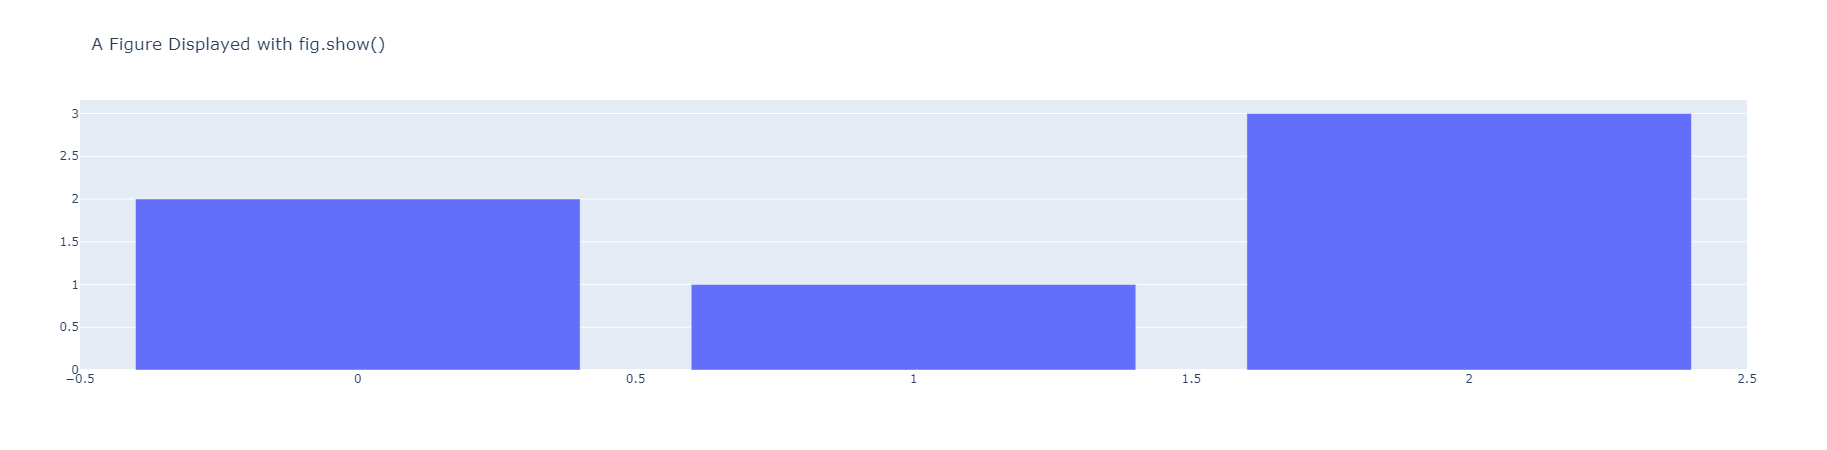

In [252]:
import plotly.graph_objects as go
fig = go.Figure(
    data=[go.Bar(y=[2, 1, 3])],
    layout_title_text="A Figure Displayed with fig.show()"
)
fig.show()


## Overall AB Split

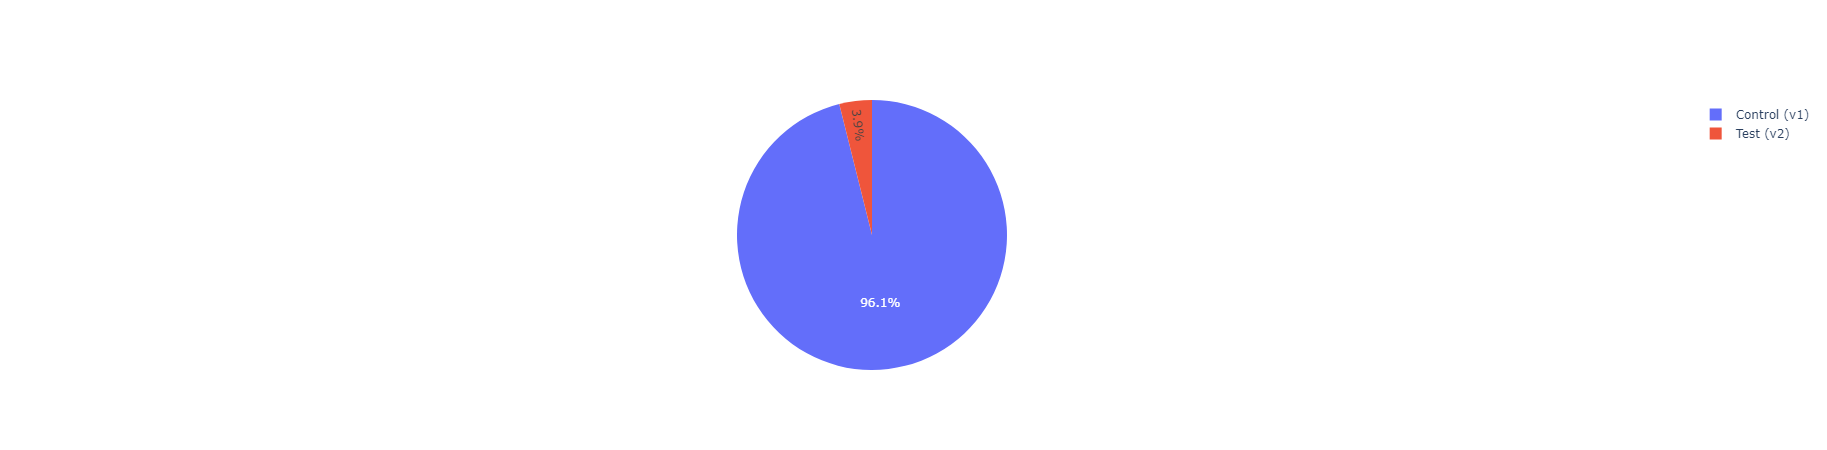

In [259]:
ab_split_summary = events.groupby("is_test").count()["sent_at"]
ab_split_summary_pretty = [[("Test (v2)" if z[0] else "Control (v1)"), z[1]] for z in ab_split_summary.iteritems()]


import plotly.graph_objects as go
fig = make_subplots(1, 1)

fig.add_trace(
    go.Pie(values=[z[1] for z in ab_split_summary_pretty], labels=[z[0] for z in ab_split_summary_pretty]),
)

                
fig.show()

## Type of Event

In [266]:
event_name_counts = events.groupby(events.event_name)
event_name_counts


In [284]:
expected_statuses = ["Article Body {}".format(i) for i in [0, 25, 50, 75, 100]]
pageview_status_counts = events[events.event_name=="Reading"].groupby([events.status, events.is_test]).count()['sent_at'] #[["event_name", "is_test" ], :]
pageview_status_counts.sort_index()
pageview_status_counts




status            is_test
Article Body 100  False      154
                  True         6
Article Body 25   False      185
                  True         5
Article Body 50   False      196
                  True         7
Article Body 75   False      162
                  True         8
Name: sent_at, dtype: int64

## Pageviews By Category

## Distribution Over Time

In [262]:
# Group by hour and plot with time axis
events.groupby([events.sent_at_timestamp.hour, events.is_test]).count()

AttributeError: 'Series' object has no attribute 'hour'

# Scroll Depth Distributions

By split:
* How far down the page does a user scroll on average (table and plot)
* Time to reach a point down the page (charts) 


# Pageview Per Session

* Where they click (future)
* 